<a href="https://colab.research.google.com/github/AklimaRimi/Reptile-Museum/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/AklimaRimi/Reptile-Museum.git

fatal: destination path 'Reptile-Museum' already exists and is not an empty directory.


In [2]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [3]:
!nvidia-smi

Fri Mar 10 14:42:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:

from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import pandas as pd
import numpy as np
import torch
from fastai.metrics import accuracy
torch.cuda.is_available()
from fastai.vision.all import *
set_seed(42)

from fastcore.parallel import *

In [5]:
df = pd.read_csv('/content/Reptile-Museum/data/final_data.csv')
df.head()

,Image,Type,Name,Scientific Name,Conservation Status,Habitant,Color,Found In,Diet
0,Reptile-Museum/augimg/Rafetus swinhoei/yRafetus swinhoei85.jpeg,Turtle,Yangtze giant softshell turtle,Rafetus swinhoei,Critically Endangered,River,Olive-Green,China,Omnivore
1,Reptile-Museum/augimg/Scelarcis perspicillata/dScelarcis perspicillata4.jpeg,Lizard,Moroccan rock lizard,Scelarcis perspicillata,Low Risk,Desert,Brown,Morocco,Insectivore
2,Reptile-Museum/augimg/Thamnophis sirtalis parietalis/yThamnophis sirtalis parietalis57.jpeg,Snake,Red-sided garter snake,Thamnophis sirtalis parietalis,Low Risk,Wet Lands,Brown,North America,Carnivore
3,Reptile-Museum/augimg/Caretta caretta/xCaretta caretta82.jpeg,Turtle,Loggerhead sea turtle,Caretta caretta,Low Risk,Ocean,Brown,All Over the World,Carnivore
4,Reptile-Museum/augimg/Mecistops cataphractus/yMecistops cataphractus67.jpeg,Crocodile,West African Slender-snouted crocodile,Mecistops cataphractus,Critically Endangered,Tropical Region,Dark-Brown,Angola,Carnivore


In [6]:
path = '/content/'

In [7]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [23]:
from fastai.vision.all import *

path = '/content/'


labels = pd.read_csv('/content/Reptile-Museum/data/final_data.csv')


with tf.device('/device:GPU:0'):
  def get_labels(row):
      return [row['Scientific Name'], row['Name'], row['Type'], row['Conservation Status'],row['Habitant'],row['Color'],row['Found In'],row['Diet']]
  def get_inp(row):
    return row['Image']

  dblock = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock(add_na = True)),
                      splitter=RandomSplitter(valid_pct=.2,seed=0),
                      get_x=get_inp,
                      get_y=get_labels,
                      item_tfms=Resize(300),
                      
      )
  dls = dblock.dataloaders(labels, bs=16)




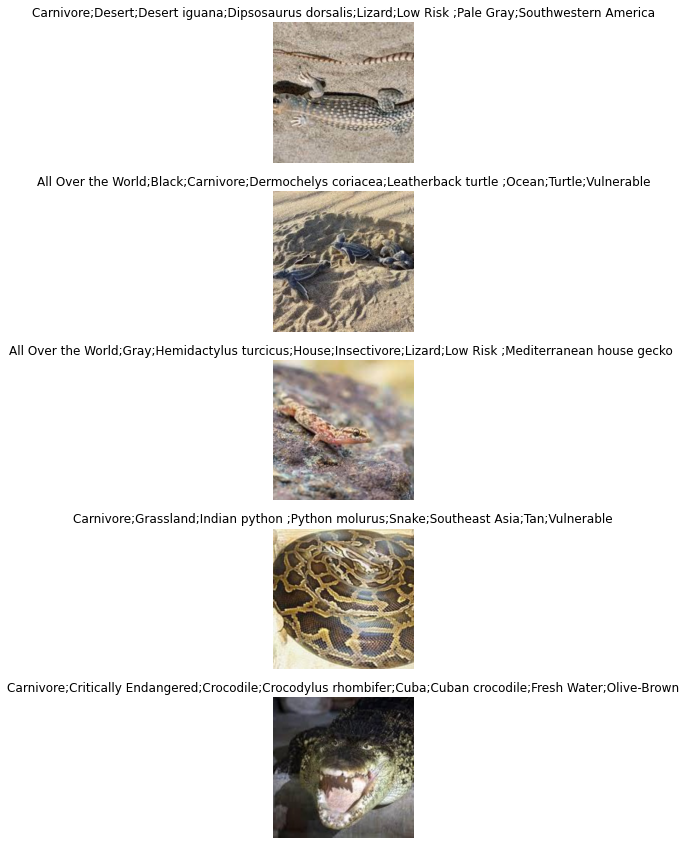

In [24]:
with tf.device('/device:GPU:0'):
  dls.train.show_batch(max_n=5,nrows=5)

In [25]:
with tf.device('/device:GPU:0'):
  learn = cnn_learner(dls, resnet50, metrics=[accuracy_multi, F1ScoreMulti(),PrecisionMulti()]).to_fp16()



/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
learn.freeze()

SuggestedLRs(valley=0.0014454397605732083)

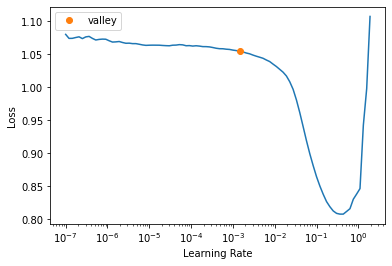

In [27]:
learn.lr_find()

In [28]:
with tf.device('/device:GPU:0'):
  learn.fit_one_cycle(1,0.0014454397605732083)



epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.039153,0.027880,0.989342,0.578603,0.795749,07:02


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
learn.unfreeze()

SuggestedLRs(valley=6.30957365501672e-05)

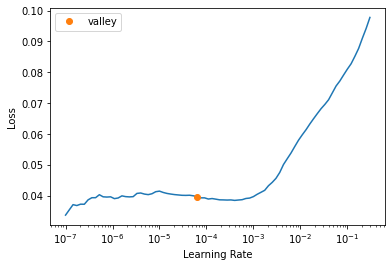

In [30]:
learn.lr_find()

In [ ]:
with tf.device('/device:GPU:0'):
  learn.fit_one_cycle(5,6.30957365501672e-05)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.031793,0.021152,0.992027,0.680703,0.848798,08:19
1,0.020640,0.012584,0.995427,0.807594,0.919869,08:19
2,0.013201,0.007654,0.997279,0.888854,0.950798,08:19
3,0.009040,0.005282,0.998176,0.930426,0.970514,08:20


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_cl

In [ ]:
with tf.device('/device:GPU:0'):  
  learn.show_results(figsize=(15,15),max_n=5,nrows=5)

In [ ]:
import pickle
with tf.device('/device:GPU:0'):
  learn.export('/content/drive/MyDrive/Colab Notebooks/multimodal/Multi target/multi_target_resnet50.pkl')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from fastai.vision.all import *
with tf.device('/device:GPU:0'):
  learn  =  load_learner('/content/drive/MyDrive/Colab Notebooks/multimodal/Multi target/multi_target_resnet50.pkl')
  preds = learn.predict('/content/Reptile-Museum/augimg/Caretta caretta/xCaretta caretta82.jpeg')

  print(preds[0])


In [ ]:
df.head()